# Week 2: Principal Component Analysis


In this workshop, we will work through a set of problems on dimensionality reduction -- a cannonical form of unsupervised learning. Within the machine learning pipeline, dimensionality reduction is an important tool, which can used in EDA to understand patterns in the data, feature engineering to create a low-dimensional representation of the inputs, and/or in the final phase when you are presenting and visualizing your solution.

As usual, the worksheets will be completed in teams of 2-3, using **pair programming**, and we have provided cues to switch roles between driver and navigator. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- Look for the 🏁 as cue to switch roles between driver and navigator.
>- In some Exercises, you will see some beneficial hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given. 

As you work through the problems it will help to refer to your lecture notes (navigator). The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 


## Outline

1. [Problem Definition and Setup](#setup)

2. [Principal Component Analysis](#pca)

  a. [Examining the Basis Vectors and Scores](#basis)

  b. [Selecting the Number of Components](#nocomponents)

  c. [Other Digits](#other)

# Problem Definition and Setup <a id='setup'></a>

## Packages

First, lets load in some packages to get us started. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data

Our dataset will be the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, which we will download from sklearn. The dataset consists of a set of greyscale images of the numbers 0-9 and corresponding labels. Usually the goal is to train a classifier (i.e. given an image, what digit does it correspond to?). Here we will throw away the labels and focus on the images themselves. Specifically, we will use dimensionality reduction to explore the images and underlying patterns and find a low-dimensional representation.

First, load the data:

In [18]:
#!pip install tensorflow_datasets

In [19]:
import tensorflow_datasets as tfds

(Xtrain, ytrain), (Xtest, ytest) = tfds.as_numpy(tfds.load(
    'mnist',
    split=['train','test'],
    batch_size=-1,
    as_supervised=True
))

X = np.vstack((Xtrain,Xtest))
y = np.concatenate((ytrain,ytest))
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

### 🚩 Exercise 1 (CORE)

What is stored in `X` and `y` in the command above? What is the shape/datatype etc if an array?


In [20]:
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


In [21]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


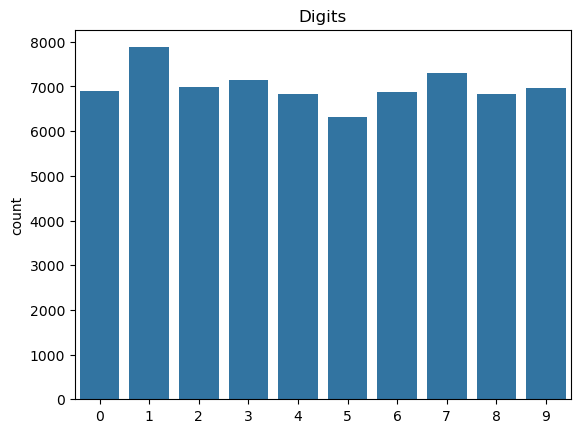

In [22]:
sns.countplot(x = y)
plt.title("Digits")
plt.show()

Now, let's create a dictionary, with the digit classes (0-9) as keys, where the correponding values are the set of all images corresponding to that particular label. 

In [32]:
digits_dict = {}
#X_= X.values
count = 0

for label in y:
  if label in digits_dict:
    digits_dict[label] += [X[count]]
  else:
    digits_dict[label] = [X[count]]
  count += 1


Next let's visualize some of the images. We will start by picking a label and plotting a few images from within the dictionary. Note that each image contains a total of 784 pixels (28 by 28) and we will need to `reshape` the image to plot with `imshow(...,cmap='gray_r')`. Try also changing the label to view different digits.

KeyError: '1'

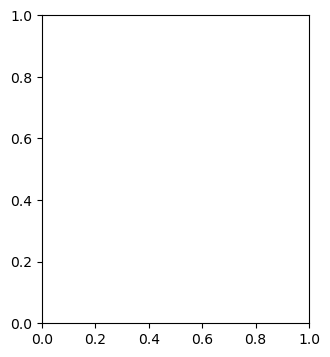

In [37]:
mylabel = '1'
n_images_per_label = 5

fig = plt.figure(figsize=(4*n_images_per_label, 4))
for j in range(n_images_per_label):
    ax_number = 1 + j
    ax = fig.add_subplot(1, n_images_per_label, ax_number)
    ax.imshow(digits_dict[mylabel][j].reshape((28,28)), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 2 (EXTRA)

Edit the code above to plot a few images for multiple labels.

<br>
<details><summary><b><u>Hint</b></u></summary>

Create a vector of labels and add additional for loop in the code above.
</details>

### 🚩 Exercise 3 (CORE)

Now focus on the 3s only and create a data matrix called `X_threes`. Define also `N` (# datapoints) and `D` (# features).

What are the features in this problem? How many features and data points are there? 

In [39]:
X_threes = np.asarray(digits_dict[3])
N, D = X_threes.shape
print('There are', N, 'data points and', D, 'features')

There are 7141 data points and 784 features


### 🚩 Exercise 4 (CORE)

Now compute and plot the mean image of three.

In [44]:
X_three_mean = np.mean(X_threes, axis=0, keepdims=True)

fig = plt.figure(figsize=())
ax = fig.subplot()
ax.imshow(X_three_mean.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

TypeError: Bbox.from_bounds() missing 2 required positional arguments: 'width' and 'height'

Run the following code to first create a new data matrix that centers the data by subtracting the mean image, and then visualise some of the images and compare to the original data. Note: you will need to replace `X_three_mean` with the name you gave the mean image in the computation above.

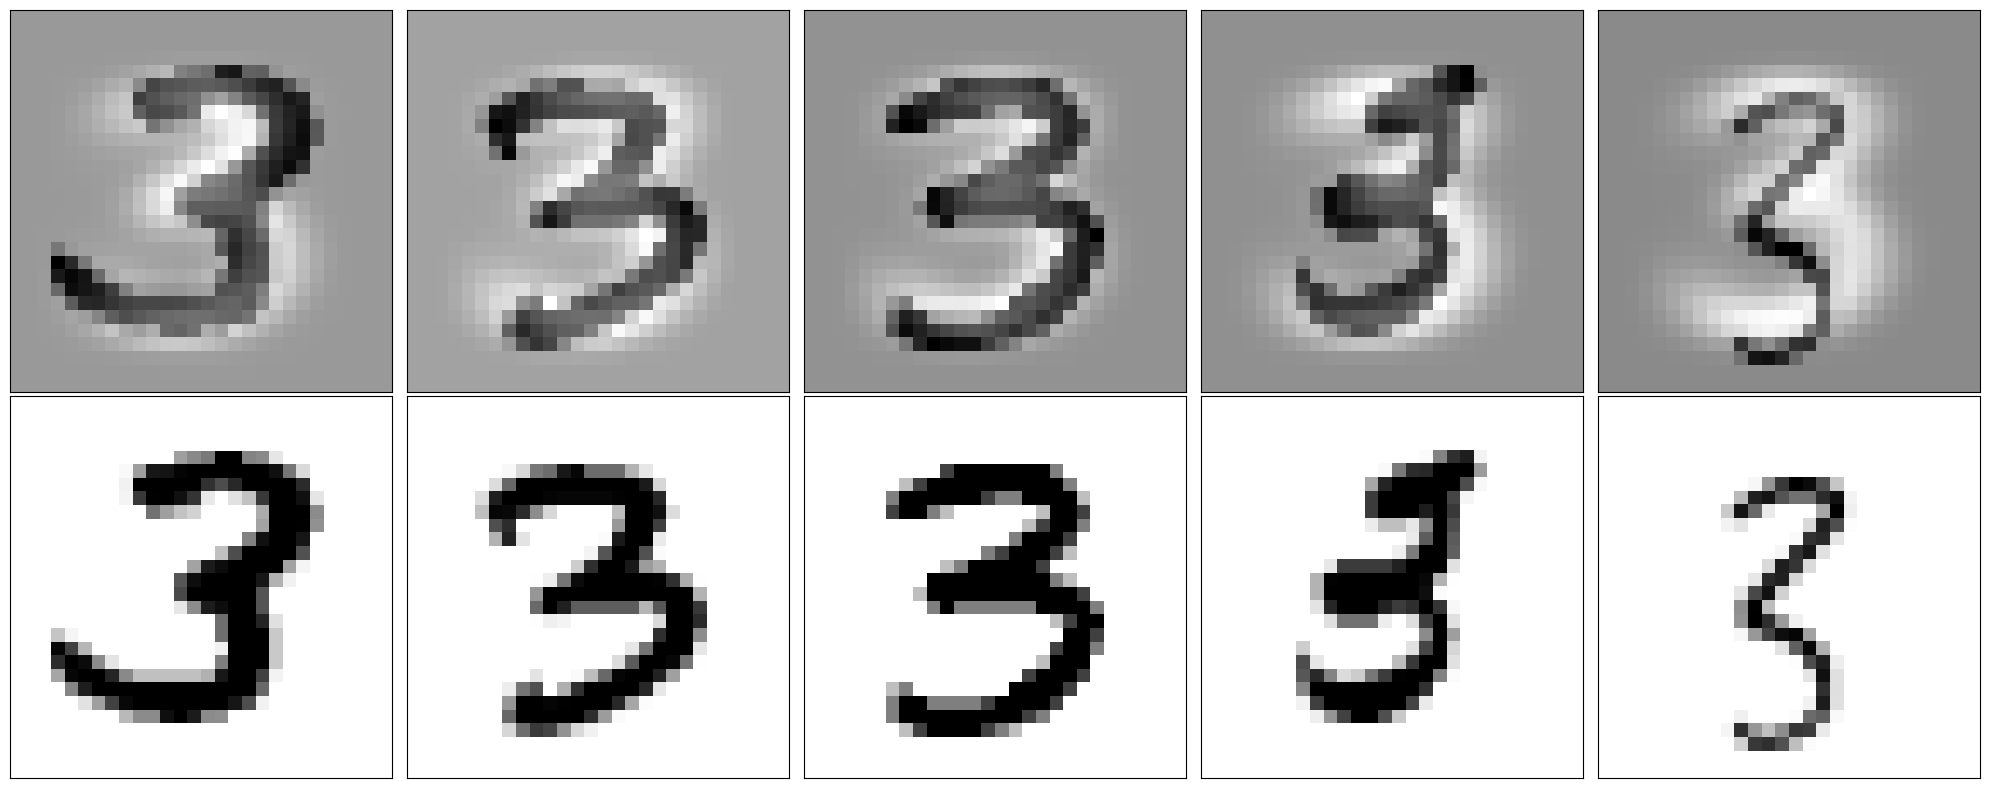

In [41]:
X_three_centred = X_threes - X_three_mean

n_images = 5

fig = plt.figure(figsize=(4*n_images, 4*2))
for j in range(n_images):
  ax = fig.add_subplot(2, n_images, j+1)
  ax.imshow(X_three_centred[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_images, j+1+n_images)
  ax.imshow(X_threes[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 5 (CORE)

Comment on whether or not the images need to be standardized before using PCA

when features have significantly different scales, those with higher variance can dominate the principal components. The features need to be centered. There are some pixels with very little variation, and we want them to have less influence on the principal components compared with the more important pixels towards the center.

🏁 **Now, is a good point to switch driver and navigator**

# PCA <a id='pca'></a>

Now, we will perform PCA to summarize the main patterns in the images. We will use the [`PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) transform from the `sklearn.decomposition` package:

- We can specify the number of components with the option `n_components`. If omitted, all components are kept.

- Note that by default the `PCA()` transform centers the variables to have zero mean (but does not scale them). After fitting, we can access the mean through the attribute `mean_`. If we also want to standardize to have not only zero mean but also unit variance, we can set `whiten=True`.

- We can access the basis vectors (principal components) through the `components_` attribute.

- We can call `fit()` to fit the model, followed by `transform` to obtain the low-dimensional representation (or also `fit_transform`). 

 First, let's create the PCA transform and call `fit()`:

In [ ]:
pca_threes = PCA(n_components = 200)
pca_threes.fit(X_threes)

## Examining the Basis Vectors and Scores <a id='basis'></a>

### 🚩 Exercise 6 (EXTRA)
 
Plot the mean image by accessing the `mean_` attribute and check that it is the same as above.

### 🚩 Exercise 7 (CORE)

Plot the the first ten basis vectors as images by accessing the `components_` attribute. Overall, what patterns do they seem describe? 

### 🚩 Exercise 8 (CORE)

a) Use the `transform()` method to compute the PCA scores and save them in an object called `scores`. Then, plot the data points in the low-dimensional space spanned by the first two principal components. 

To better interpret the latent dimensions, let's look at some projected points along each dimension and the corresponding images. Specifically, run the following code to:

- first compute the $5, 25, 50, 75, 95\%$ quantiles of the scores for the first two dimensions
- then find the data point whose projection is closest to each combination of quantiles.

In [71]:
s1q = np.quantile(scores[:,0],[.05,.25,.5,.75,.95])
s2q = np.quantile(scores[:,1],[.05,.25,.5,.75,.95])

idx = np.zeros([len(s1q),len(s2q)])

for i in range(len(s1q)):
    for j in range(len(s2q)):
        aux = ((scores[:,0] - s1q[i])**2 + (scores[:,1] - s2q[j])**2).reshape(N,1)
        idx[i,j] = np.where(aux == min(aux))[0][0]

idx = idx.astype(int)

b) Now, add these points in red to your plot above in.

c) Run the following code to plot the images corresponding to this grid of points. Describe the general pattern of the first (left to right) and second (down to up) principal component.

In [ ]:
fig, ax = plt.subplots(len(s1q),len(s2q),figsize=(6,6))
for i in range(len(s1q)):
    for j in range(len(s2q)):
        ax[len(s2q)-1-j,i].imshow(X_threes[idx[i,j],:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

You can also try to create some artificial images, by fixing different values of the weights. This can also help to interpret the latent dimensions. 

In [ ]:
weight1 = [-1000,-500,0,500,1000]
weight2 = 0

images_pc1 = np.zeros([len(weight1),D])

count = 0
for w in weight1:   
    images_pc1[count,:] =(pca_threes.mean_ + pca_threes.components_[0,:]*w+pca_threes.components_[1,:]*weight2)
    count += 1
    

fig, ax = plt.subplots(1,len(weight1),figsize=(10,6))
for i in range(len(weight1)):
    ax[i].imshow(images_pc1[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

### 🚩 Exercise 9 (CORE)

Repeat this to describe the third principal component. Look at the histogram of its scores to decide what values of weights to use. 

### 🚩 Exercise 10 (EXTRA)

In lecture, we saw that we can also compute the basis vectors from an SVD decomposition of the data matrix. Use the `svd` function in `scipy.linalg` to compute the first three basis vectors and verify that they are the same (up to a change in sign -- note that the signs may be flipped because each principal component specifies a direction in the $D$-dimensional space and flipping the sign has no effect as the direction does not change). 

Does `PCA()` perform principal component analysis using an eigendecomposition of the empirical covariance matrix or using a SVD decomposition of the data matrix?

🏁 **Now, is a good point to switch driver and navigator**

## Selecting the Number of Components <a id='nocomponents'></a>

### 🚩 Exercise 11 (CORE)

Next, let's investigate how many components are needed by considering how much variance is explained by each component.

Note that the `pca_threes` object has an attribute `explained_variance_` (variance of each component) and `explained_variance_ratio_` (proportion of variance explained by each component). 

Plot both the proportion of variance explained and the cummulative proportion of variance explained. Provide a suggestion of how many components to use. How much variance is explained by the suggest number of components? Comment on why we may be able to use this number of components in relation to the total number of features.

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `cumsum()` to compute the cummulative sum of the elements in a vector.
</details>

NameError: name 'pca_threes' is not defined

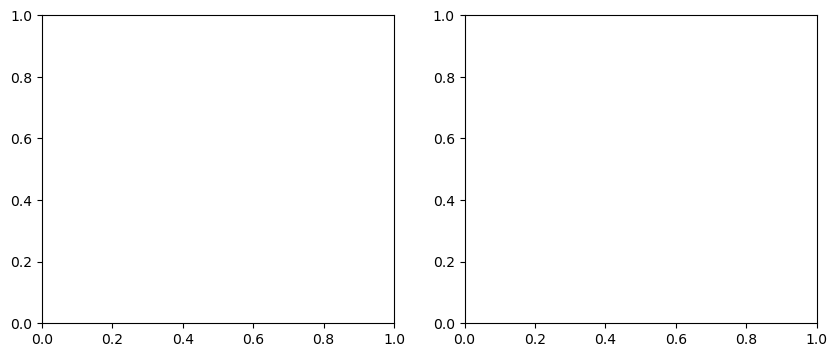

In [45]:
fig, ax = plt.subplots(1,2)
ax[0].plot(ticks, pca_threes.explained_variance_ratio_, marker='o')
ax[1].plot(ticks, pca_threes.explained_variance_ratio_.cumsum(), marker='o')
plt.show()

In [47]:
sum(pca_threes.explained_variance_ratio_[range(7)])

NameError: name 'pca_threes' is not defined

Using 7 components allows us to explain approximately $46%$ of the variance. Due to the high correlation among pixels, a substantial portion of the variance can be captured using $L << D$ components.

### 🚩 Exercise 12 (CORE)

For your selected number of components, compute the reconstruted images. Plot the reconstruction for a few images and compare with the original images. Comment on the results.  

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `inverse_transform()` to decode the scores.
</details>

TypeError: Invalid shape (784,) for image data

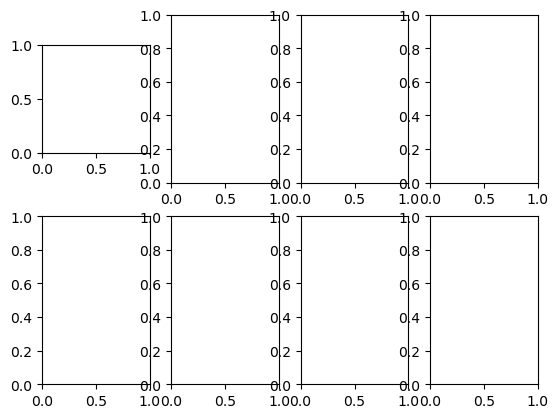

In [49]:
scores_n7 = PCA(n_components = 7).fit(X_threes).transform(X_threes)
Xr = pca_threes_n7.inverse_transform(scores_n7)

num_imgs= 5
fig, ax = plt.subplots(2,n)
for n in range(num_imgs):
  ax[0,n].imshow(X_threes[n,:], cmap='gray_r')
  ax[1,n].imshow(X_r[n,:], cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

🏁 **Now, is a good point to switch driver and navigator**

## Other Digits <a id='other'></a>

Now, let's consider another digit. 

### 🚩 Exercise 13 (CORE)

Perform PCA for another choice of digit. What do the first two components describe? Do some digits have better approximations than others? Comment on why this may be.

In [ ]:
X_sevens = np.asarray(digits_dict['7'])
N, D = X_sevens.shape

pca_sevens = PCA(n_components = 50)
pca_sevens.fit(X_sevens)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(pca_sevens.mean_, cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

In [ ]:
num_plot = 5
fig, ax = plt.subplots(1,5)
for n in range(num_plot):
  ax[n].imshow(pca_sevens.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2)
ticks = np.arange(pca_sevens.n_components_)+1
ax[0].plot(ticks, pca_sevens.explained_variance_ratio_, marker='o')
ax[1].plot(ticks, pca_sevens.explained_variance_ratio_.cumsum(), marker='o')
plt.show()

In [ ]:
print(sum(pca_sevens.explained_variance_ratio_[range(8)]))
print(sum(pca_sevens.explained_variance_ratio_[range(7)]))

There is an elbow around 8 components, which is approximately 56% of the variance. The PVE seems to be slightly higher than for 3. 

### Exercise 14 (EXTRA)

Finally, consider now two digits of your choice (edit the code below if you wish to pick different digits).


In [90]:
# Extract data 
X_twodigits = np.concatenate((digits_dict['3'], digits_dict['8']))
N, D = X_twodigits.shape

Run the following code to compute and plot the mean and some of the principle components for this dataset. 

In [ ]:
# Fit PCA
pca_digits = PCA(n_components = 50)
pca_digits.fit(X_twodigits)

In [ ]:
# Plot the mean image
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(pca_digits.mean_.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

In [ ]:
# Plot basis vectors
n_plot = 5
fig, ax = plt.subplots(1,5,figsize=(10,4))
for n in range(n_plot):
  ax[n].imshow(pca_digits.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

Plot the projection of the data in the latent space and color the data by the labels. What do you observe?

Try also to generate artificial images and decsribe how images change along the PCs. 

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please go to Edit -> Edit Notebook Metadata and change 'Student 1' and 'Student 2' in the **name** attribute to include your name.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF.

In [ ]:
!jupyter nbconvert --to pdf mlp_week02.ipynb 